In [1]:
! pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [1]:
! nvidia-smi

Tue Feb  4 21:23:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.17                 Driver Version: 561.17         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P3             19W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from evaluate import load  # Updated import for metrics

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")



[nltk_data] Downloading package punkt to C:\Users\Duong's
[nltk_data]     Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [10]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer, 
                               batch_size=16, device=device, 
                               column_text="article", 
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):
        
        inputs = tokenizer(article_batch, max_length=1024,  truncation=True, 
                        padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device), 
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''
        
        # Finally, we decode the generated texts, 
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, 
                                clean_up_tokenization_spaces=True) 
               for s in summaries]      
        
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]
        
        
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

### Load data

Link: https://huggingface.co/datasets/samsum

In [12]:
from datasets import load_dataset

# Load the samsum dataset with trust_remote_code=True
dataset_samsum = load_dataset("samsum", trust_remote_code=True)

# Get split lengths
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][1]["summary"])


Generating validation split: 100%|██████████| 818/818 [00:00<00:00, 4479.16 examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


# Evaluating PEGASUS on SAMSum

In [13]:
dataset_samsum['test'][0]['dialogue']

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [15]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_samsum['test'][0]['dialogue'] )

print(pipe_out)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


In [16]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [18]:
rouge_metric = load('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8)

  0%|          | 0/103 [01:46<?, ?it/s]


KeyboardInterrupt: 

In [16]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = {rn: score[rn] for rn in rouge_names}  # Nếu score[rn] là số
pd.DataFrame(rouge_dict, index=['pegasus'])


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.015565,0.000294,0.01554,0.015546


# Histogram

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


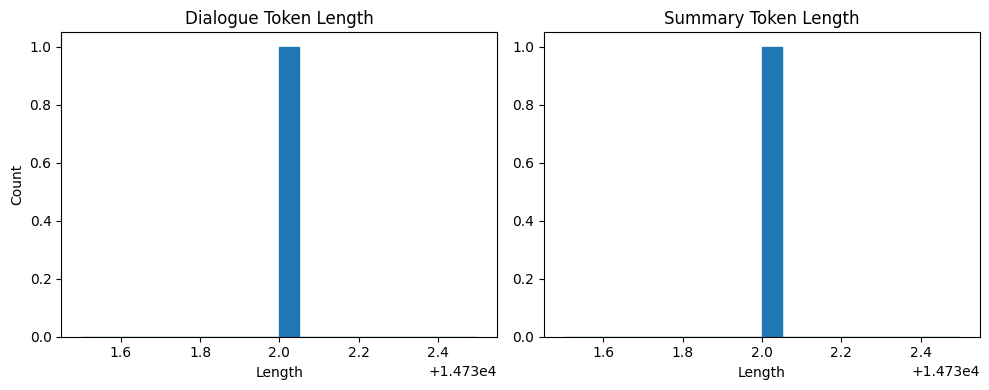

In [17]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [18]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )
        
    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }
    
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:3953: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [19]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [20]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
) 

c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:

trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

C:\Users\tanhu\AppData\Local\Temp\ipykernel_16304\2808958116.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model_pegasus, args=trainer_args,


In [22]:
trainer.train()


  0%|          | 0/920 [00:00<?, ?it/s]

{'loss': 51.1917, 'grad_norm': 322.675048828125, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 51.6194, 'grad_norm': 155.32968139648438, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 46.7576, 'grad_norm': 181.9234619140625, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 45.6488, 'grad_norm': 234.8658905029297, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 43.047, 'grad_norm': 271.6858825683594, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 43.6432, 'grad_norm': 197.83963012695312, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 42.0576, 'grad_norm': 165.8318634033203, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 38.879, 'grad_norm': 150.94505310058594, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 39.9999, 'grad_norm': 120.03338623046875, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 39.4346, 'grad_norm': 105.51403045654297, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 35.7668, 'grad_nor

  0%|          | 0/818 [00:00<?, ?it/s]

{'eval_loss': 1.4834067821502686, 'eval_runtime': 311.8071, 'eval_samples_per_second': 2.623, 'eval_steps_per_second': 2.623, 'epoch': 0.54}
{'loss': 27.1226, 'grad_norm': 75.75696563720703, 'learning_rate': 4.880952380952381e-05, 'epoch': 0.55}
{'loss': 26.7106, 'grad_norm': 52.9421272277832, 'learning_rate': 4.761904761904762e-05, 'epoch': 0.56}
{'loss': 27.0101, 'grad_norm': 69.33999633789062, 'learning_rate': 4.642857142857143e-05, 'epoch': 0.58}
{'loss': 25.3494, 'grad_norm': 80.65489196777344, 'learning_rate': 4.523809523809524e-05, 'epoch': 0.59}
{'loss': 27.3585, 'grad_norm': 97.36041259765625, 'learning_rate': 4.404761904761905e-05, 'epoch': 0.6}
{'loss': 27.4388, 'grad_norm': 106.43995666503906, 'learning_rate': 4.2857142857142856e-05, 'epoch': 0.61}
{'loss': 27.1503, 'grad_norm': 73.35022735595703, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.62}
{'loss': 26.2535, 'grad_norm': 97.37670135498047, 'learning_rate': 4.047619047619048e-05, 'epoch': 0.63}
{'loss': 24.5272, '

c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'train_runtime': 23579.2198, 'train_samples_per_second': 0.625, 'train_steps_per_second': 0.039, 'train_loss': 29.208029473346212, 'epoch': 1.0}


TrainOutput(global_step=920, training_loss=29.208029473346212, metrics={'train_runtime': 23579.2198, 'train_samples_per_second': 0.625, 'train_steps_per_second': 0.039, 'total_flos': 5528248038285312.0, 'train_loss': 29.208029473346212, 'epoch': 0.9991854466467553})

In [24]:
# Tính toán score
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size=2, column_text='dialogue', column_summary='summary'
)

# Kiểm tra định dạng của score và điều chỉnh mã
try:
    rouge_dict = {rn: score[rn].mid.fmeasure for rn in rouge_names}
except AttributeError:
    # Nếu `score[rn]` không có thuộc tính `mid`, dùng trực tiếp giá trị
    rouge_dict = {rn: score[rn] for rn in rouge_names}

# Tạo DataFrame
pd.DataFrame(rouge_dict, index=['pegasus'])


100%|██████████| 410/410 [1:55:16<00:00, 16.87s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.018762,0.000344,0.018557,0.018572


In [25]:
## Save model
model_pegasus.save_pretrained("pegasus-samsum-model")

In [26]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\spiece.model',
 'tokenizer\\added_tokens.json',
 'tokenizer\\tokenizer.json')

# Test

In [27]:
dataset_samsum = load_dataset("samsum")

In [28]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [29]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

In [30]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

Device set to use cpu


In [31]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.
